In [1]:
import pandas as pd, numpy as np, seaborn as sns
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


In [5]:
# Load BRCA dataset
ml_dataset_path = '../data/dataset_multilabel.pkl'
with open(ml_dataset_path, 'rb') as file:
    dataset = pickle.load(file) 
    X_brca = dataset.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                    'Subtype-from Parker centroids', 'MaxCorr',
                        'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y_brca = dataset['Subtype-from Parker centroids']


# Load CRIS dataset
label_values = ['CRIS.A', 'CRIS.B', 'CRIS.C', 'CRIS.D', 'CRIS.E']
with open('../data/tcga_cris_raw_24356_620samples.pkl', 'rb') as file:
    dataset = pickle.load(file) 
X_cris = dataset.drop(columns=['Patient ID', 'Subtype-from Parker centroids'] + label_values, inplace=False)
y_cris = dataset['Subtype-from Parker centroids']

In [6]:
# Compare the genes form BRCA and CRIS dataset
print('Common genes:')
len(set(X_brca.columns).intersection(set(X_cris.columns)))

Common genes:


17114

In [7]:
with open('../data/feat50.pkl', 'rb') as file:
    feat50 = pickle.load(file) 

with open('../data/correlated_features_08.pkl', 'rb') as file:
    corr_feat = pickle.load(file) 

set(feat50).intersection(set(corr_feat))

FileNotFoundError: [Errno 2] No such file or directory: '../data/correlated_features_08.pkl'

In [18]:
from data_preprocessing import remove_extreme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from utils import log_transform

# Use cancer specific dataset
X, y = X_brca, y_brca

# Remove extreme values (genes, samples) from initial preprocessing
X, potential_samples_to_remove, \
    feat_to_remove, feat_to_keep = remove_extreme(X, change_X = True)

# Split the dataset
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                    random_state=1, shuffle=True, stratify=y)  

# Encode the class labels
LB = LabelEncoder() 
y_train = pd.Series(LB.fit_transform(y_train), index=y_train.index)
y_test = LB.transform(y_test)

# Data standardization | normalization
X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
scaler = FunctionTransformer(log_transform)
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


There are 0 columns with more than 80% of Null values!
There are 22722 columns with more than 20% of count values greater than 4!


In [9]:
remove_corr_feat = False

# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

if remove_corr_feat:
    corr_features = correlation(X_train_scaled, 0.8)
    print('correlated features: ', len(set(corr_features)) )

    with open('../data/correlated_features_08.pkl', 'wb') as file:
        pickle.dump(list(set(corr_features)), file)
else:
    with open('../data/correlated_features_08.pkl', 'rb') as file:
        corr_features = pickle.load(file)

# Remove correlated features
X_train_scaled = X_train_scaled.drop(columns=corr_features)
X_train_scaled

FileNotFoundError: [Errno 2] No such file or directory: '../data/correlated_features_08.pkl'

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 1000
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
X_train_selected_kbest

,A2ML1,ABAT,ABCA13,ABCC11,ABCC8,ABLIM3,ABTB2,ACADSB,ACBD4,ACE2,...,ZNF454,ZNF462,ZNF467,ZNF552,ZNF587,ZNF670-ZNF695,ZNF695,ZNF703,ZNF763,ZNF814
225,-2.050456,6.235758,-2.096476,2.089319,3.980527,4.995204,4.251042,5.376071,3.987564,-2.354501,...,-0.629313,4.391634,5.229189,6.814213,6.879178,1.499188,1.939991,8.024337,2.354478,6.089181
598,-0.982464,5.620867,-2.997826,7.707925,4.942180,6.302771,2.449090,7.186747,2.945099,-2.675091,...,-0.538480,5.152345,4.787756,3.240962,4.876604,-1.177447,-2.534477,7.166321,1.485231,4.414978
405,-1.173796,6.408448,-2.030408,4.434958,2.043535,4.430176,0.233094,7.409356,1.504012,-3.321928,...,-0.743737,2.350015,0.567388,6.617840,5.929090,0.317623,0.303556,3.042350,1.522554,5.983261
265,5.918910,2.483358,-1.928260,-0.040500,-2.771039,2.041034,2.025465,3.629003,2.750115,2.433315,...,0.584815,5.108070,2.749217,2.976227,4.234619,2.984769,3.744542,4.707676,1.784751,3.995615
955,0.811845,3.572643,-3.304834,4.012581,3.368940,3.588720,2.949395,5.959206,2.886902,-1.405241,...,-1.514697,3.088915,5.740348,4.443134,4.162750,-1.728427,-1.205640,6.462758,1.011239,3.717069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,-2.873832,6.699458,-2.371754,8.323628,2.136522,5.459071,1.826570,8.808552,4.124580,-2.387906,...,0.102580,3.169815,3.267384,7.136506,6.105192,-0.322813,-0.712937,7.423128,2.309464,5.319449
765,-2.262172,6.738774,-2.819798,5.421944,2.371607,5.931625,3.460396,6.135081,3.733245,-2.596895,...,-2.415625,0.523490,3.995264,5.715511,5.708715,1.385551,2.131375,7.984382,2.548009,5.616123
137,-0.456085,4.622806,-0.191239,3.681104,5.222662,5.039976,2.589833,4.997043,3.578618,-1.265866,...,-0.201089,4.868910,4.082683,4.967788,5.078921,0.663333,1.055005,7.427151,2.100207,4.937450
244,5.123030,3.660404,0.089408,0.792025,-2.976719,4.731199,3.609198,4.621584,2.097957,-1.716893,...,1.094685,4.413322,2.565383,3.006979,4.639340,1.629583,3.145826,3.689363,1.767233,4.301779


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

min_features_to_select = 300  # Minimum number of features to consider
for i in range(4, 14):
    clf = RandomForestClassifier(n_estimators=100, random_state=i)
    cv = StratifiedKFold(5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=1,
        verbose=2
    )
    rfecv.fit(X_train_selected_kbest, y_train)

    feat_fr_rfecv = X_train_selected_kbest.loc[:, rfecv.support_].columns
    num_feat_selected = len(feat_fr_rfecv)

    with open('../data/cris/new2_without_corr_removed_feature_selection_{}_randomstate_{}.pkl'.format(num_feat_selected, i), 'wb') as file:
        pickle.dump(feat_fr_rfecv, file)


Fitting estimator with 1000 features.
Fitting estimator with 999 features.
Fitting estimator with 998 features.
Fitting estimator with 997 features.
Fitting estimator with 996 features.
Fitting estimator with 995 features.
Fitting estimator with 994 features.
Fitting estimator with 993 features.
Fitting estimator with 992 features.
Fitting estimator with 991 features.
Fitting estimator with 990 features.
Fitting estimator with 989 features.
Fitting estimator with 988 features.
Fitting estimator with 987 features.
Fitting estimator with 986 features.
Fitting estimator with 985 features.
Fitting estimator with 984 features.
Fitting estimator with 983 features.
Fitting estimator with 982 features.
Fitting estimator with 981 features.
Fitting estimator with 980 features.
Fitting estimator with 979 features.
Fitting estimator with 978 features.
Fitting estimator with 977 features.
Fitting estimator with 976 features.
Fitting estimator with 975 features.
Fitting estimator with 974 features.


In [ ]:
feat_fr_rfecv = X_train_selected_kbest.loc[:, rfecv.support_].columns
len(feat_fr_rfecv)

NameError: name 'X_train_selected_kbest' is not defined

In [206]:
with open('../data/cris/feature_selection_{}_randomstate_{}.pkl'.format(0, 0), 'wb') as file:
        pickle.dump(feat_fr_rfecv, file)

In [21]:
import os
from re import search

dict_of_feat = {}
for i in range(4, 14):
    files = os.listdir('../data/brca/')
    search_string = 'randomstate_' + str(i)
    file_to_find = [filename for filename in files if filename.__contains__(search_string) and filename.startswith('without_corr')]
    path = '../data/brca/' + file_to_find[0]
    with open(path, 'rb') as file:
        list_of_features = pickle.load(file)
        for feature in list_of_features:
            if feature not in dict_of_feat:
                dict_of_feat[feature] = 0
            dict_of_feat[feature] += 1

        if i == 4:
            intersec = set(list_of_features)
        else:
            intersec = intersec.intersection(set(list_of_features))

dict_of_feat, len(intersec)

({'A2ML1': 6,
  'ABAT': 6,
  'ABCC11': 10,
  'ABCC8': 6,
  'ABLIM3': 1,
  'ACADSB': 10,
  'ACBD4': 9,
  'ACE2': 10,
  'ACOX2': 9,
  'ADCY9': 8,
  'ADIRF': 8,
  'AFF3': 10,
  'AGR2': 9,
  'AGR3': 10,
  'AKR7A3': 9,
  'AMER1': 4,
  'ANKRD30A': 10,
  'ANLN': 9,
  'ANXA8': 10,
  'ANXA9': 9,
  'APH1B': 8,
  'AR': 10,
  'ARFGEF3': 9,
  'ARHGAP11A': 9,
  'ARHGEF38': 6,
  'ARHGEF4': 7,
  'ARL3': 7,
  'ARMT1': 10,
  'ART3': 7,
  'ASPM': 10,
  'AURKA': 10,
  'AURKB': 9,
  'B3GNT5': 8,
  'BBOF1': 9,
  'BBOX1': 10,
  'BCAM': 5,
  'BCAS1': 9,
  'BCL11A': 10,
  'BCL2': 10,
  'BECN1': 7,
  'BIRC5': 10,
  'BPI': 1,
  'BTG2': 9,
  'BUB1': 10,
  'BUB1B': 7,
  'C11orf91': 7,
  'C16orf71': 1,
  'C1orf168': 3,
  'C1orf64': 6,
  'C1QL2': 4,
  'C1QL4': 8,
  'C22orf23': 8,
  'C5AR2': 10,
  'C5orf30': 4,
  'C6orf15': 7,
  'C9orf152': 10,
  'C9orf40': 3,
  'C9orf64': 4,
  'CA12': 10,
  'CA6': 2,
  'CACNA2D2': 10,
  'CAPN13': 8,
  'CCDC125': 10,
  'CCDC170': 10,
  'CCDC191': 4,
  'CCDC71L': 2,
  'CCDC74B': 9,
  

In [22]:
sorted_dict = {k: v for k, v in sorted(dict_of_feat.items(), key=lambda item: item[1], reverse=True)}
len(sorted_dict)

879

In [23]:
pd.Series(dict_of_feat)

A2ML1      6
ABAT       6
ABCC11    10
ABCC8      6
ABLIM3     1
          ..
ZNF462     2
LCA5L      1
MKL2       1
POU4F1     1
PRLR       1
Length: 879, dtype: int64

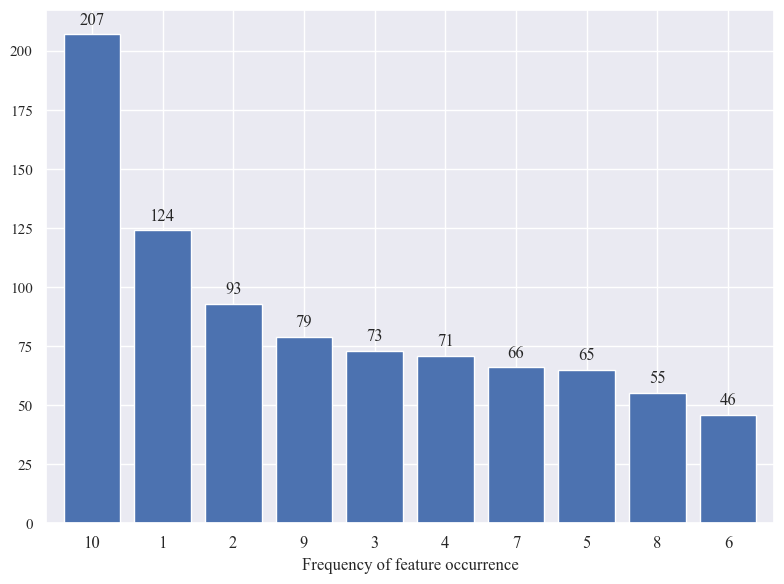

In [26]:
plt.figure(figsize=(8, 6))
ax = pd.Series(dict_of_feat).value_counts().plot(kind='bar', title='', width=0.8)

# Add text annotations for bar heights
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
plt.xticks(rotation=0)
plt.xlabel('Frequency of feature occurrence')

plt.tight_layout()

In [58]:
with open('../data/cris/new2_without_corr_removed_feat_select_union.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [59]:
# Value to be removed
value_to_remove = 1

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}
len(sorted_dict)

660

In [60]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_10_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [61]:
# Value to be removed
value_to_remove = 2

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

551

In [62]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_20_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [63]:
# Value to be removed
value_to_remove = 3

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

490

In [64]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_30_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [65]:
# Value to be removed
value_to_remove = 4

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

440

In [66]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_40_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [67]:
# Value to be removed
value_to_remove = 5

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

388

In [68]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_50_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [69]:
# Value to be removed
value_to_remove = 6

# Create a new dictionary without keys that have the given value
sorted_dict = {key: value for key, value in sorted_dict.items() if value != value_to_remove}

len(sorted_dict)

329

In [70]:
with open('../data/cris/new2_without_corr_removed_feat_select_gt_60_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

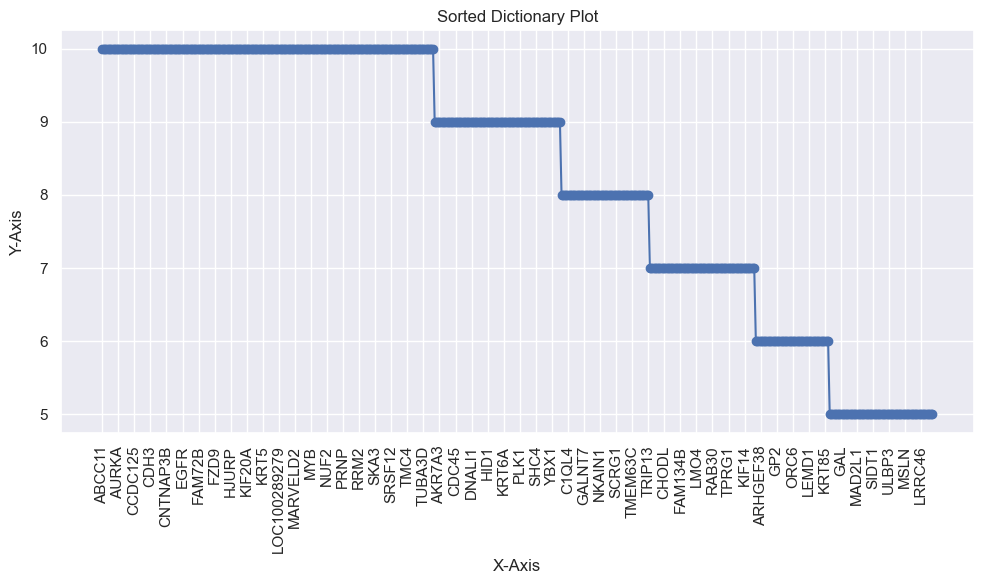

In [185]:
# Extract keys and values from the dictionary
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(keys, values, marker='o')

# Set x-axis ticks every 20th key
xticks = keys[::10]
plt.xticks(xticks, rotation=90)

# Adding labels and title
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Sorted Dictionary Plot')

# Show the plot
plt.tight_layout()

In [107]:
sorted_dict.keys()

dict_keys(['ABCC11', 'ACADSB', 'ACBD4', 'ACE2', 'ACOX2', 'ADCY9', 'AFF3', 'AGR2', 'ANKRD30A', 'ANLN', 'ANP32E', 'ANXA8', 'ANXA9', 'APH1B', 'AR', 'ARHGEF38', 'ARMT1', 'ARSG', 'AURKA', 'B3GNT5', 'BBOF1', 'BBOX1', 'BCAS1', 'BCL11A', 'BCL2', 'BLM', 'BTG2', 'C10orf90', 'C1orf64', 'C6orf15', 'C9orf152', 'CA12', 'CACNA2D2', 'CCNE1', 'CCNE2', 'CDC25B', 'CDC7', 'CDCA7', 'CENPN', 'CENPW', 'CHEK1', 'CHST2', 'CHST3', 'CIB3', 'CKS1B', 'CMBL', 'CNTNAP3', 'CPLX1', 'CRYAB', 'CT62', 'CTPS1', 'CX3CL1', 'CXCL1', 'CXXC5', 'DBF4', 'DEGS2', 'DMD', 'DNMT3B', 'DSCC1', 'DUSP7', 'EGFR', 'EPHB6', 'ERBB2', 'ERBB3', 'ERBB4', 'EZH2', 'FABP7', 'FAM120AOS', 'FAM134C', 'FAM171A1', 'FAM63A', 'FBXO5', 'FERMT1', 'FGD3', 'FSIP1', 'FZD9', 'GABRP', 'GALNT10', 'GARS', 'GDF5', 'GPM6B', 'GREB1', 'GTPBP4', 'HID1', 'HRCT1', 'ID4', 'IFNAR2', 'IGF1R', 'IGFBP4', 'IL1RL2', 'IL22RA2', 'IL34', 'IL6ST', 'ITFG2', 'JADE2', 'KCNJ11', 'KCNK15', 'KCNS1', 'KDM4B', 'KLK5', 'KRT16', 'KRT79', 'LAMP5', 'LBR', 'LDHB', 'LINC00092', 'LINC00839', 'L

In [71]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 500
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
X_train_selected_kbest

,AAR2,ABAT,ABCC2,ABCC6P2,ABHD3,ABLIM2,AC004593.3,AC005256.1,AC018359.1,AC068121.1,...,YTHDF1,YWHAB,ZBTB7C,ZFP64,ZGPAT,ZMYND8,ZNF663P,ZNF696,ZSWIM1,ZSWIM3
109,5.983784,3.850234,-0.448249,-0.218400,5.398519,4.352346,-2.031090,0.266768,0.629195,-2.696645,...,6.422889,8.827993,4.805658,5.140489,2.860202,5.823491,-0.810516,2.823817,4.498009,3.440931
236,5.997899,5.231119,-1.095497,-1.879799,3.959302,6.291972,-0.884780,-2.335505,-0.820867,-0.644540,...,6.732631,9.297858,4.522812,4.979550,4.420753,7.074713,0.760909,3.593527,4.278462,3.642527
510,6.706753,5.313672,3.096097,0.380250,3.916435,5.557695,-0.432774,-3.058580,-0.027455,-3.321928,...,7.518055,9.708068,2.719942,5.219109,4.692293,6.787955,1.596369,3.054972,5.128686,3.471752
282,5.756601,3.578882,-1.108682,-3.069234,5.232706,4.425107,-1.686995,-2.095412,-1.108682,-3.321928,...,6.589943,8.791826,4.152845,4.734064,3.113856,6.643963,-3.321928,2.418241,4.345834,2.969709
243,6.265408,4.557457,1.211486,-0.828037,4.514873,3.999372,-1.388334,-2.833551,-3.057172,-0.728379,...,6.772637,9.385640,1.758454,4.959800,3.487883,6.249835,-2.639986,3.176899,3.385934,3.597578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,6.548183,5.624939,4.150141,0.427125,4.945918,5.523755,0.853447,-3.085842,-0.505336,-3.321928,...,6.742280,9.289082,4.364540,5.421534,3.518658,6.124314,1.691158,2.731788,4.277281,3.527582
203,6.176145,4.419198,2.633640,-1.311965,3.871158,5.296786,-0.851631,-1.992024,-0.989376,-3.321928,...,7.066370,9.344967,3.905570,5.040028,3.485637,7.041717,-0.503193,3.142400,4.893419,3.100576
66,6.052289,5.456046,3.713397,0.147684,4.624386,3.577916,0.930263,-2.145773,-0.224583,-3.321928,...,6.936196,9.735309,3.966870,5.036115,2.288950,6.413057,0.443328,3.065620,4.162233,3.515717
385,5.531789,2.641788,1.660361,-3.321928,4.832403,2.940330,-0.528947,-1.601335,-1.877373,-3.321928,...,6.176693,8.400189,-0.116173,5.758247,3.125663,6.113122,-3.069379,3.598634,3.549978,1.728576


In [72]:
same_feat = set(X_train_selected_kbest.columns).intersection(set(sorted_dict.keys()))

In [188]:
# Given set of keys to include
keys_to_include = list(same_feat)

# Create a new dictionary with only the selected keys
new_dict = {key: sorted_dict[key] for key in keys_to_include if key in sorted_dict}
new_dict

{'FAM83D': 10,
 'TTYH1': 10,
 'SUOX': 10,
 'CENPA': 9,
 'KCNG1': 7,
 'RARRES1': 9,
 'SYTL5': 7,
 'MTFR2': 10,
 'TTK': 10,
 'EXO1': 9,
 'PRR11': 9,
 'CDH3': 10,
 'ERGIC1': 7,
 'CDCA7': 10,
 'CT62': 10,
 'FERMT1': 10,
 'NEK10': 10,
 'MSLN': 5,
 'SLC39A6': 10,
 'LINC01117': 6,
 'CDC45': 9,
 'LINC00092': 10,
 'DEPDC1': 7,
 'SLC7A5': 8,
 'CACNA2D2': 10,
 'RGS22': 10,
 'LRRC46': 5,
 'MELK': 10,
 'IL6ST': 9,
 'ACADSB': 10,
 'KCNJ11': 10,
 'CDCA2': 5,
 'PI3': 8,
 'SRSF12': 10,
 'STAC': 5,
 'HID1': 9,
 'SGO1': 10,
 'MLPH': 10,
 'GREB1': 10,
 'HRCT1': 9,
 'PTTG3P': 9,
 'CFAP99': 10,
 'CXXC5': 6,
 'PRR15': 10,
 'CCDC170': 10,
 'INPP5J': 10,
 'LINC00504': 10,
 'SGO1-AS1': 10,
 'KRT6C': 10,
 'CFAP69': 5,
 'MTHFD1L': 5,
 'TTC36': 10,
 'POU5F1': 5,
 'PCP2': 5,
 'CCNB2': 10,
 'LINC01016': 10,
 'CLSTN2': 8,
 'CHST2': 10,
 'FAM72C': 10,
 'C11orf91': 7,
 'SCUBE2': 10,
 'PADI2': 10,
 'ERBB4': 9,
 'SKA3': 10,
 'MAPK4': 8,
 'SKA1': 10,
 'CHAD': 9,
 'TRIM3': 10,
 'CCNA2': 10,
 'XBP1': 10,
 'DNAJC12': 8,
 'AU

In [115]:
new_sorted_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1], reverse=True)}
new_sorted_dict

{'SUOX': 10,
 'RARRES1': 10,
 'CDCA7': 10,
 'CT62': 10,
 'FERMT1': 10,
 'LINC01117': 10,
 'LINC00092': 10,
 'IGFBP4': 10,
 'SLC7A5': 10,
 'CACNA2D2': 10,
 'RGS22': 10,
 'IL6ST': 10,
 'ACADSB': 10,
 'KCNJ11': 10,
 'CKS1B': 10,
 'SRSF12': 10,
 'STAC': 10,
 'HID1': 10,
 'GREB1': 10,
 'HRCT1': 10,
 'LBR': 10,
 'CXXC5': 10,
 'KCNS1': 10,
 'LINC01016': 10,
 'CHST2': 10,
 'SCUBE2': 10,
 'BBOX1': 10,
 'ERBB4': 10,
 'MAPK4': 10,
 'TRIM3': 10,
 'ANKRD30A': 10,
 'FZD9': 10,
 'JADE2': 10,
 'KCNK15': 10,
 'LOC105375624': 10,
 'PGPEP1': 10,
 'DEGS2': 10,
 'TCEAL1': 10,
 'RERG': 10,
 'SCCPDH': 10,
 'CA12': 10,
 'CENPN': 10,
 'ANLN': 10,
 'STMN1': 10,
 'SLC16A6': 10,
 'LOC102723854': 10,
 'GDF5': 10,
 'BCAS1': 10,
 'SERPINB5': 10,
 'KRT16': 10,
 'PHGDH': 10,
 'PDSS1': 10,
 'GPM6B': 10,
 'KDM4B': 10,
 'LDHB': 10,
 'FSIP1': 10,
 'CHEK1': 10,
 'NEK5': 10,
 'SLC7A8': 10,
 'AR': 10,
 'ADCY9': 10,
 'PARD6B': 10,
 'TSPAN15': 10,
 'OCA2': 10,
 'SLC6A2': 10,
 'NXNL2': 10,
 'CENPW': 10,
 'EGFR': 10,
 'AURKA': 1

In [219]:
with open('../data/cris/without_corr_removed_feat_select_gt_50_perc_occur.pkl', 'wb') as file:
    pickle.dump(list(sorted_dict.keys()), file)

In [73]:
# Compare features from CRIS and BRCA

with open('../data/cris/new2_without_corr_removed_feat_select_gt_40_perc_occur.pkl', 'rb') as file:
    feat_50_cris = pickle.load(file)
with open('../data/brca/without_corr_removed_feat_select_gt_50_perc_occur.pkl', 'rb') as file:
    feat_50_brca = pickle.load(file)

intersec_feat_50 = set(feat_50_cris).intersection(set(feat_50_brca))
len(intersec_feat_50), intersec_feat_50

(21,
 {'AGR2',
  'AGR3',
  'AKR7A3',
  'BCAM',
  'BCL11A',
  'F7',
  'GPR160',
  'HEXIM1',
  'KCNK5',
  'KRT16',
  'KRT6A',
  'MLPH',
  'MOB3B',
  'PPP1R14C',
  'PRR15',
  'REEP1',
  'SERPINB5',
  'SIDT1',
  'SLC44A4',
  'TSPAN1',
  'TSPAN13'})

In [82]:
# Initialize SelectKBest with the desired number of features and ANOVA F-test
num_features_to_select = 582
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit and transform the selector on the data
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
X_train_selected_kbest = X_train_scaled.loc[:, X_train_scaled.columns[selected_feature_indices]]
len(set(X_train_selected_kbest.columns).intersection(set(feat_fr_rfecv)))

387